In [3]:
library(ggpubr)
library(ggrepel)
library(ggplotify)
library(pheatmap)
library(stringr)
library(dendsort)
library(patchwork)
library(tidyverse)
library(readxl)
theme_set(theme_pubr(base_size = 10))

Loading required package: ggplot2

── Attaching core tidyverse packages ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [4]:
suppressMessages(library(data.table))
suppressMessages(library(ggplot2))
suppressMessages(library(topGO))
suppressMessages(library(clusterProfiler))
suppressMessages(library(ggpubr))
suppressMessages(library(DOSE))
suppressMessages(library(GOSemSim))
suppressMessages(library(enrichplot))
suppressMessages(library(ggthemes))
suppressMessages(library(viridis))
suppressMessages(library(ggraph))
suppressMessages(library(igraph))

In [5]:
gene_id_to_name <- read.table("../data/gene_id_to_name/gene_id_to_name_comprehensive.tsv", sep = "\t", header = T, row.names = 1, stringsAsFactors = F)

get_name <- function(gene_id) {
  return(gene_id_to_name[gene_id, "gene_name"])
}



writeEKG <- function(ekg, prefix) {
  ekg <- as.data.frame(ekg)
  ekg$GOID <- sapply(strsplit(ekg$ID, "GO:"), function(x) gsub(")", "", paste0("GO:", x[2])), simplify = FALSE)
  ekg$GOID <- as.character(ekg$GOID)
  ekg.geneID <- strsplit(as.character(ekg$geneID), "/", fixed = TRUE)
  ekg.genes <- lapply(ekg.geneID, get_name)
  ekg$geneID <- ekg.genes
  ekg$geneID <- vapply(ekg$geneID, paste, collapse = ", ", character(1L))
  
  write.table(ekg, paste(prefix, "tsv", sep = "."), sep = "\t")
  return(ekg)
}

In [6]:
te.down.df <- read_xlsx("../data//Feb_2021_Kadosh_C_albicans_Biofilm_Planktonic_merged_TE_withprop (3) with TE and DE sets.xlsx",
                     sheet = "TE>=2-fold down")
te.up.df <- read_xlsx("../data//Feb_2021_Kadosh_C_albicans_Biofilm_Planktonic_merged_TE_withprop (3) with TE and DE sets.xlsx",
                     sheet = "TE >=2-fold up")
de.down.df <- read_xlsx("../data//Feb_2021_Kadosh_C_albicans_Biofilm_Planktonic_merged_TE_withprop (3) with TE and DE sets.xlsx",
                     sheet = "DE>=2-fold down")
de.up.df <- read_xlsx("../data//Feb_2021_Kadosh_C_albicans_Biofilm_Planktonic_merged_TE_withprop (3) with TE and DE sets.xlsx",
                     sheet = "DE>=2-fold up")


te.down.genes <- gene_id_to_name[te.down.df$gene_id, "gene_name"]
te.up.genes <- gene_id_to_name[te.up.df$gene_id, "gene_name"]
de.down.genes <- gene_id_to_name[de.down.df$gene_id, "gene_name"]
de.up.genes <- gene_id_to_name[de.up.df$gene_id, "gene_name"]

In [7]:
all.genes.df <- read_xlsx("../data//Feb_2021_Kadosh_C_albicans_Biofilm_Planktonic_merged_TE_withprop (3) with TE and DE sets.xlsx",
                     sheet = "Original Dataset")
universe <- all.genes.df[all.genes.df$prop_tpm_above_1_planktonic_rna_annotated>=0.33 |  all.genes.df$prop_tpm_above_1_biofilm_rna_annotated>=0.33,]
universe.genes <- gene_id_to_name[universe$gene_id, "gene_name"]

In [8]:
universe.genes

[1] "SCW4"      "C2_06060C" "C1_09910C" "TLO9"      "C2_03710W" "C2_08340C"
   [7] "CR_07820W" "ALS6"      "CR_08740W" "SPC34"     "C1_02510W" "C4_06360C"
  [13] "C1_07480C" "CRD2"      "CR_07970C" "C1_14480W" "C7_02430C" "CR_05150W"
  [19] "C3_02580C" "SKO1"      "CR_06790C" "C4_03340C" "C1_08240C" "TAR1"     
  [25] "MNN22"     "C1_01680C" "C2_00810C" "SRT1"      "CR_06060W" "CR_07260C"
  [31] "C4_00990W" "C3_02870C" "C3_02200W" "C4_04630C" "CR_07640C" "C2_08030W"
  [37] "UGA33"     "CRZ2"      "C4_05830W" "SPO11"     "C4_06040W" "C4_00820W"
  [43] "VAN1"      "BUL4"      "C4_00810C" "PGA61"     "C4_06640C" "C4_00190W"
  [49] "ARP2"      "C3_07980C" "CAN3"      "DCC1"      "C7_03380W" "KTI11"    
  [55] "C2_07860W" "C4_03190W" "SSP96"     "C1_11020W" "C2_05520W" "FMT1"     
  [61] "KAR5"      "C3_01660W" "C4_04010W" "C1_09700W" "ELC1"      "C7_02260W"
  [67] "C1_01190C" "CR_03270W" "C4_00030C" "C1_05610W" "RAM2"      "CR_03930C"
  [73] "C4_04390W" "C5_03880C" "C5_03730W" "C1_03050W" "ZCF22"     "C6_04230W"
  [79] "C2_00270C" "C4_02580W" "C2_01630W" "C4_01990W" "ARO80"     "C2_09210W"
  [85] "C2_06300W" "CR_03080C" "C5_03700C" "C2_09510C" "CR_04710W" "C6_03390W"
  [91] "CR_05800C" "C3_01140W" "C3_01590W" "C5_04140W" "C2_06790W" "C1_02060W"
  [97] "C1_10960W" "C5_04380C" "TPO4"      "CR_01360W" "C5_01420W" "ATO6"     
 [103] "C1_00320W" "RFX1"      "CR_05860W" "CR_04850C" "C5_05240C" "C4_03500C"
 [109] "OPT5"      "C7_01990C" "C2_00570W" "CR_08380C" "MED19"     "C1_13750C"
 [115] "C6_01120C" "C1_12930C" "CDC45"     "C3_00120W" "C2_05390C" "NUP"      
 [121] "RPL37B"    "BUD5"      "C7_02140W" "C1_05400C" "C1_00510W" "C2_07910C"
 [127] "PGA37"     "C4_03460C" "DAD1"      "C5_04980W" "C3_03020W" "GTT13"    
 [133] "C3_00010C" "SIW14"     "HSP31"     "C5_01440C" "C1_09650W" "C5_00230C"
 [139] "C1_01750W" "C2_10730W" "C1_08910C" "ILV1"      "C1_13790C" "C1_06380C"
 [145] "C1_12940C" "SOD6"      "C5_05010W" "C1_13150W" "C3_00530C" "C2_02670C"
 [151] "CR_00010C" "CR_01770C" "CHT4"      "C5_02320C" "C4_05340W" "ANB1"     
 [157] "C3_07130W" "CR_02600W" "C3_02070C" "C7_00770W" "C3_04420W" "MRS2"     
 [163] "C2_00420W" "CR_10800C" "C6_01080C" "C1_06700W" "C2_08660C" "C5_04990W"
 [169] "CAG1"      "PRE8"      "MLH1"      "C3_00910W" "C1_02720W" "VMA22"    
 [175] "C2_05490W" "C1_06440C" "DAL5"      "MAD2"      "CR_03430W" "C4_03400W"
 [181] "C2_01060C" "CR_03730C" "C2_08990C" "C1_01800W" "OFI1"      "C4_05730W"
 [187] "TRX2"      "SUT1"      "C2_06930C" "SHA3"      "C2_04000C" "C3_02840W"
 [193] "C1_12740W" "LYS144"    "HGT16"     "C7_01670W" "C1_00020C" "C4_00920C"
 [199] "C1_09930W" "CCW14"     "C5_01040W" "CR_04280C" "C1_05480C" "C1_13460W"
 [205] "COX11"     "C3_00340W" "C3_05510W" "EST1"      "C4_00260W" "CR_03330W"
 [211] "C1_10420C" "C3_05330C" "C1_10920W" "C4_05360C" "CRH12"     "C1_12840W"
 [217] "STE13"     "CR_04140W" "C6_01680C" "C6_00340C" "C1_01930W" "C4_03750C"
 [223] "RTA3"      "C1_09550W" "C6_03420W" "SPR28"     "ARG11"     "PGA44"    
 [229] "DUR32"     "C1_04700C" "INP51"     "C1_04340C" "C7_03460W" "CR_06780W"
 [235] "C2_08060W" "C2_02630W" "CR_08450C" "C1_05980W" "C2_09810C" "C1_10630C"
 [241] "CR_09660W" "C4_01670C" "PGA48"     "CR_00820C" "OYE2"      "MPS1"     
 [247] "CR_10280W" "IFI3"      "C2_09410W" "C3_03310C" "MSW1"      "CR_07370W"
 [253] "C4_01130C" "CR_00220W" "TEP1"      "C5_05060C" "C3_02250C" "C2_02550C"
 [259] "C1_02200C" "ULP1"      "C6_02250W" "C2_02580W" "C5_00250C" "C3_01780C"
 [265] "CR_08710W" "DAD2"      "TRS33"     "LIG4"      "CR_04220C" "C4_06710W"
 [271] "C3_05860C" "C4_02510W" "C5_01730W" "C1_05720W" "MNN10"     "FGR43"    
 [277] "C2_07240C" "MTLA2"     "NAT5"      "CR_06990W" "CR_06740W" "CDC13"    
 [283] "IRE1"      "C4_02210W" "HSP30"     "CR_08440W" "C3_06540C" "LIP5"     
 [289] "C4_00210W" "CR_07940W" "CR_05880W" "C3_02530W" "APL2"      "C2_05990C"
 [295] "C5_01050C" "FMO1"      "C3_02650W" "C2_08260W" "ENA21"     "C1_12700W"
 [301] "MRV2"      "C4_04400C" "C2_07180W" "C4_01660W

In [20]:
dim(all.genes.df)

[1] 6213   97

In [21]:
dim(universe)

[1] 5861   97

In [9]:
GO2geneID <- as.data.frame(fread("../data/gene_id_to_name/GO2geneID_slim_named.tsv"))


In [1]:
GO2geneID

ERROR: Error in eval(expr, envir, enclos): object 'GO2geneID' not found


# TE up

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


../plots/Ontology_slim_revised//TE/TE_up.tsv

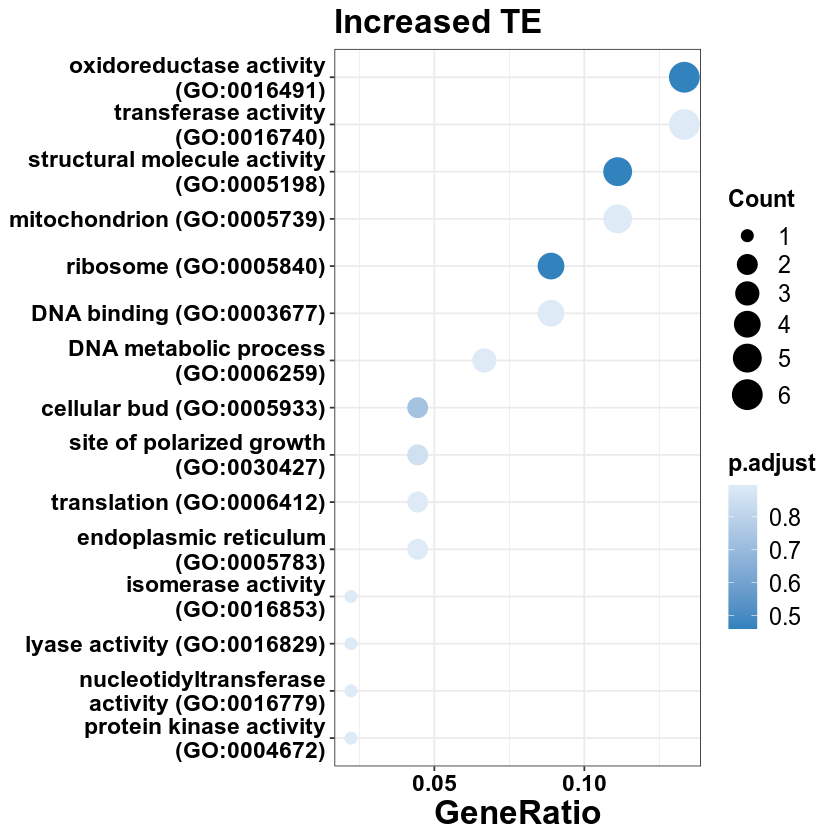

In [28]:
egmt <- enricher(te.up.genes, pvalueCutoff = 1, universe = universe.genes, pAdjustMethod = "fdr", qvalueCutoff = 1, TERM2GENE = GO2geneID)
dotplot(egmt, showCategory = 15) + scale_color_gradient(low = "#3182bd", high = "#deebf7") + labs_pubr(base_size = 20) + ggtitle("Increased TE")


directory <- "TE"
filename <- "TE_up"
ggsave(file.path("../plots/Ontology_slim_revised/", directory, paste0(filename, ".pdf")), width = 13, height = 8)
ggsave(file.path("../plots/Ontology_slim_revised/", directory, paste0(filename, ".png")), width = 13, height = 8)
fwrite(as.data.frame(egmt), file = file.path("../plots/Ontology_slim_revised/", directory, paste0(filename, ".tsv")))
cat(file.path("../plots/Ontology_slim_revised/", directory, paste0(filename, ".tsv")))

# TE down

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


../plots/Ontology_slim_revised//TE/TE_down.tsv

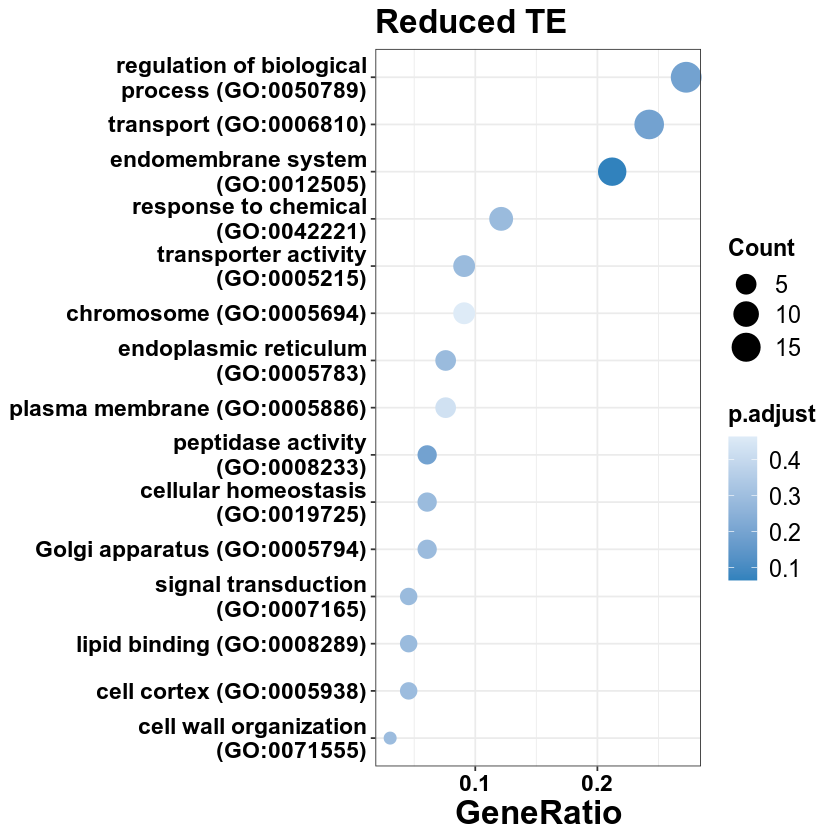

In [31]:
egmt <- enricher(te.down.genes, pvalueCutoff = 1, universe = universe.genes, pAdjustMethod = "fdr", qvalueCutoff = 1, TERM2GENE = GO2geneID)
dotplot(egmt, showCategory = 15) + scale_color_gradient(low = "#3182bd", high = "#deebf7") + labs_pubr(base_size = 20) +
ggtitle("Reduced TE")


directory <- "TE"
filename <- "TE_down"
ggsave(file.path("../plots/Ontology_slim_revised/", directory, paste0(filename, ".pdf")), width = 13, height = 8)
ggsave(file.path("../plots/Ontology_slim_revised/", directory, paste0(filename, ".png")), width = 13, height = 8)
fwrite(as.data.frame(egmt), file = file.path("../plots/Ontology_slim_revised/", directory, paste0(filename, ".tsv")))
cat(file.path("../plots/Ontology_slim_revised/", directory, paste0(filename, ".tsv")))

# DE up

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


../plots/Ontology_slim_revised//DE_rna/DE_up.tsv

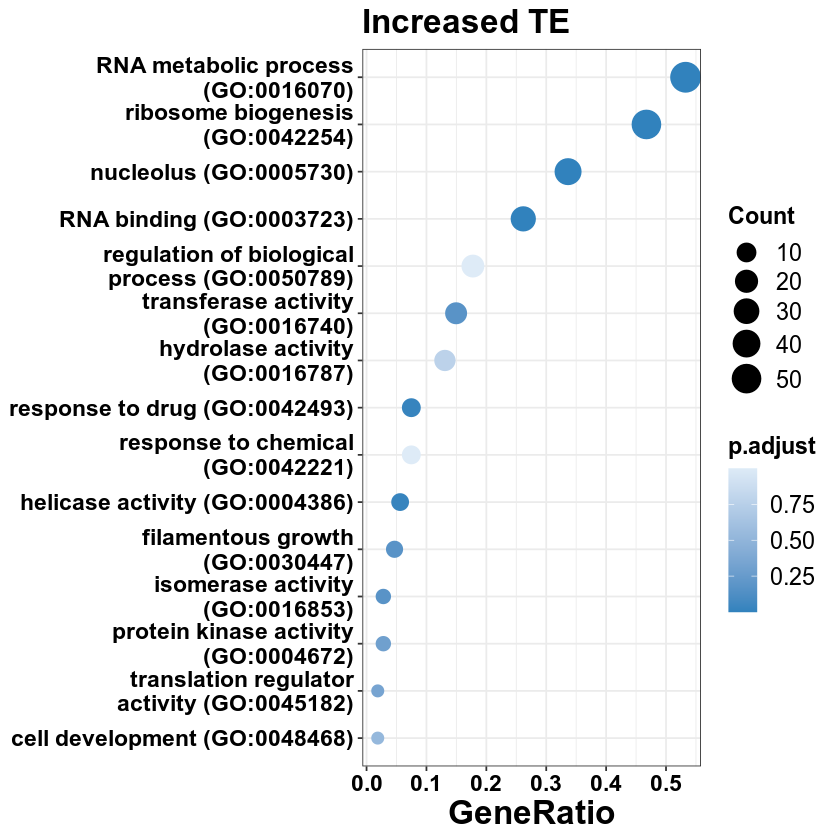

In [29]:
egmt <- enricher(de.up.genes, pvalueCutoff = 1, universe = universe.genes, pAdjustMethod = "fdr", qvalueCutoff = 1, TERM2GENE = GO2geneID)
dotplot(egmt, showCategory = 15) + scale_color_gradient(low = "#3182bd", high = "#deebf7") + labs_pubr(base_size = 20) + 
ggtitle("Increased DE")


directory <- "DE_rna"
filename <- "DE_up"
ggsave(file.path("../plots/Ontology_slim_revised/", directory, paste0(filename, ".pdf")), width = 13, height = 8)
ggsave(file.path("../plots/Ontology_slim_revised/", directory, paste0(filename, ".png")), width = 13, height = 8)
fwrite(as.data.frame(egmt), file = file.path("../plots/Ontology_slim_revised/", directory, paste0(filename, ".tsv")))
cat(file.path("../plots/Ontology_slim_revised/", directory, paste0(filename, ".tsv")))

# Decreased DE

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


../plots/Ontology_slim_revised//DE_rna/DE_down.tsv

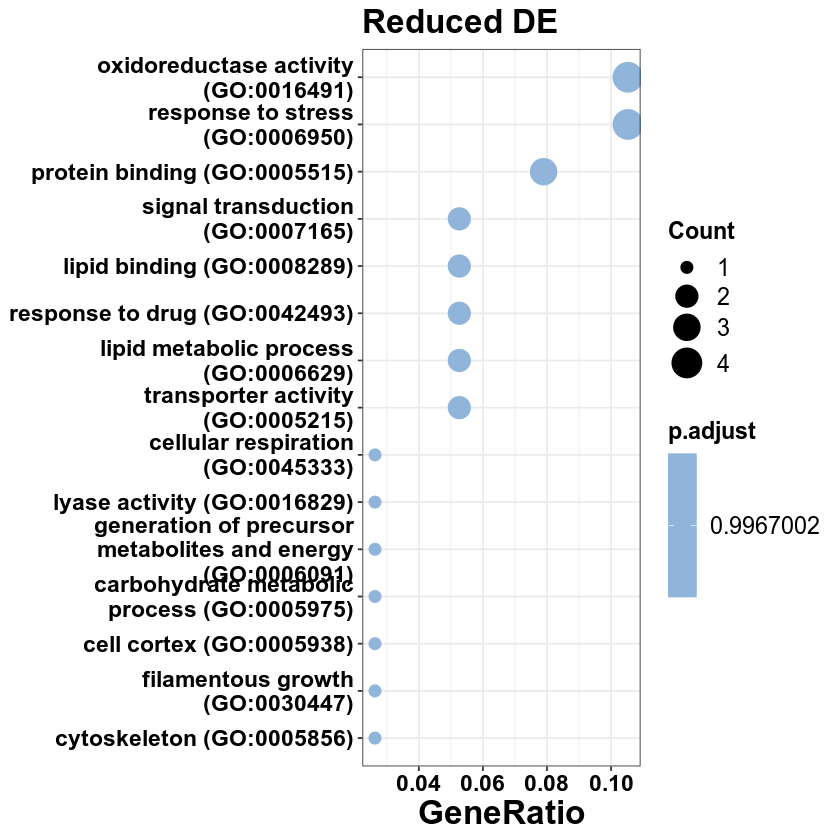

In [30]:
egmt <- enricher(de.down.genes, pvalueCutoff = 1, universe = universe.genes, pAdjustMethod = "fdr", qvalueCutoff = 1, TERM2GENE = GO2geneID)
dotplot(egmt, showCategory = 15) + scale_color_gradient(low = "#3182bd", high = "#deebf7") + labs_pubr(base_size = 20) + 
ggtitle("Reduced DE")


directory <- "DE_rna"
filename <- "DE_down"
ggsave(file.path("../plots/Ontology_slim_revised/", directory, paste0(filename, ".pdf")), width = 13, height = 8)
ggsave(file.path("../plots/Ontology_slim_revised/", directory, paste0(filename, ".png")), width = 13, height = 8)
fwrite(as.data.frame(egmt), file = file.path("../plots/Ontology_slim_revised/", directory, paste0(filename, ".tsv")))
cat(file.path("../plots/Ontology_slim_revised/", directory, paste0(filename, ".tsv")))